# Question Answering Transformer

## Extractive Question Answering 
Question answering (QA) is a task of natural language processing that aims to automatically answer questions. The goal of *extractive* QA is to identify the portion of the text that contains the answer to a question. For example, when tasked with answering the question 'When will Jane go to Africa?' given the text data 'Jane visits Africa in September', the question answering model will highlight 'September'.

### Data Preprocessing 

In [1]:
from datasets import load_from_disk

In [2]:
babi_dataset = load_from_disk('data/')

In [3]:
babi_dataset['train'][12]

{'story': {'answer': ['', '', 'kitchen'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['2']],
  'text': ['The office is south of the bathroom.',
   'The kitchen is north of the bathroom.',
   'What is the bathroom south of?'],
  'type': [0, 0, 1]}}

In [4]:
babi_dataset['train'][102]

{'story': {'answer': ['', '', 'bedroom'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['2']],
  'text': ['The bedroom is west of the office.',
   'The bedroom is east of the hallway.',
   'What is east of the hallway?'],
  'type': [0, 0, 1]}}

Take a look at the format of the data. For a given story, there are two sentences which serve as the context, and one question. Each of these phrases has an ID. There is also a supporting fact ID which refers to a sentence in the story that helps answer the question. For example, for the question 'What is east of the hallway?', the supporting fact 'The bedroom is east of the hallway' has the ID '2'. There is also the answer, 'bedroom' for the question.

In [5]:
type_set = set()

for story in babi_dataset['train']: 
    if str(story['story']['type']) not in type_set: 
        print(story['story']['type'])
        type_set.add(str(story['story']['type']))

[0, 0, 1]


In [6]:
type_set

{'[0, 0, 1]'}

To make the data easier to work with, you will flatten the dataset to transform it from a dictionary structure to a table structure.

In [7]:
flattened_babi = babi_dataset.flatten()

In [8]:
print(babi_dataset, '\n \n', flattened_babi)

DatasetDict({
    train: Dataset({
        features: ['story'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story'],
        num_rows: 1000
    })
}) 
 
 DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})


In [9]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

Now it is much easier to access the information you need! You can now easily extract the answer, question, and facts from the story, and also join the facts into a single entry under 'sentences'.

In [10]:
def get_question_and_facts(story):
    dic = {} 
    dic['question'] = story['story.text'][2]
    dic['sentences'] = ' '.join([story['story.text'][0], story['story.text'][1]])
    dic['answer'] = story['story.answer'][2]
    return dic

In [11]:
processed = flattened_babi.map(get_question_and_facts)

In [12]:
processed['train'][2]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'answer': 'bedroom'}


The goal of extractive QA is to find the part of the text that contains the answer to the question. You will identify the position of the answer using the indexes of the string. For example, if the answer to some question was 'September', you would need to find the start and end string indices of the word 'September' in the context sentence 'Jane visits Africa in September.'

Use this next function to get the start and end indices of the answer in each of the stories in your dataset.

In [13]:
def get_start_end_idx(story): 
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])

    return {'str_idx': str_idx, 'end_idx': end_idx }

In [14]:
processed = processed.map(get_start_end_idx)

In [15]:
processed['train'][12]

{'story.answer': ['', '', 'kitchen'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The office is south of the bathroom.',
  'The kitchen is north of the bathroom.',
  'What is the bathroom south of?'],
 'story.type': [0, 0, 1],
 'question': 'What is the bathroom south of?',
 'sentences': 'The office is south of the bathroom. The kitchen is north of the bathroom.',
 'answer': 'kitchen',
 'str_idx': 41,
 'end_idx': 48}

In [16]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'answer': 'garden', 'str_idx': 28, 'end_idx': 34}
answer: garden


### Tokenize and Align with HuggingFace Library

Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that you align the start and end indices with the tokens associated with the target answer word with a tokenize_and_align() function. In this case, since you are interested in the start and end indices of the answer, you will want to align the index of the sentence to match the index of the token for a word.

In [17]:
from transformers import DistilBertTokenizer

In [18]:
tokenizer = DistilBertTokenizer.from_pretrained('tokenizer/')

In [19]:
def tokenize_align(example):
    # Tokenize the input
    encoding = tokenizer(example['sentences'],
                         example['question'], 
                         truncation=True,
                         padding=True, 
                         max_length=tokenizer.model_max_length
                        )
    
    # Find the token indices corresponding to the start and end character positions
    tokens = tokenizer.encode(example['sentences'])
    
    # You'll need to implement a custom method to map character indices to token indices
    def find_token_index(char_idx):
        current_text = ""
        for i, token_id in enumerate(tokens):
            token = tokenizer.decode([token_id])
            current_text += token
            if len(current_text) >= char_idx:
                return i
        return tokenizer.model_max_length

    start_positions = find_token_index(example['str_idx'])
    end_positions = find_token_index(example['end_idx'])
    
    return {
        'input_ids': encoding['input_ids'], 
        'attention_mask': encoding['attention_mask'],  # Corrected from 'encoding_mask'
        'start_positions': start_positions, 
        'end_positions': end_positions
    }

In [20]:
qa_dataset = processed.map(tokenize_align)

In [21]:
qa_dataset = qa_dataset.remove_columns(['story.answer','story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [22]:
qa_dataset['train'][200]

{'question': 'What is north of the bathroom?',
 'sentences': 'The garden is north of the bathroom. The hallway is south of the bathroom.',
 'answer': 'garden',
 'str_idx': 4,
 'end_idx': 10,
 'input_ids': [101,
  1996,
  3871,
  2003,
  2167,
  1997,
  1996,
  5723,
  1012,
  1996,
  6797,
  2003,
  2148,
  1997,
  1996,
  5723,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  5723,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'start_positions': 0,
 'end_positions': 2}

The goal of extractive QA is to identify the portion of the text that contains the answer to a question.
Transformer models are often trained by tokenizers that split words into subwords.
Before processing, it is important that you align the start and end indices with the tokens associated with the target answer word.

### Training
Now that you have finished tokenizing and aligning your data, you can feed it into a pre-trained 🤗 Transformer model! You will use a DistilBERT model, which matches the tokenizer you used to preprocess your data.

In [23]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [24]:
from transformers import TFDistilBertForQuestionAnswering, DistilBertConfig

In [25]:
config = DistilBertConfig.from_json_file('model/tensorflow/config.json')
config.return_dict = False
model = TFDistilBertForQuestionAnswering.from_config(config)

2024-12-17 10:41:39.247851: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-17 10:41:39.247880: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-17 10:41:39.247885: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-17 10:41:39.247913: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-17 10:41:39.247923: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Tensorflow Implementation

In this notebook, we will execute two implementations, one in tensorflow and one in pytorch

Train and test datasets
Note:

- In the TensorFlow implementation, you will have to set the data format type to tensors, which may create ragged tensors (tensors of different lengths).
- You will have to convert the ragged tensors to normal tensors using the to_tensor() method, which pads the tensors and sets the dimensions to [None, tokenizer.model_max_length] so you can feed different size tensors into your model based on the batch size.

In [26]:
import tensorflow as tf 
import keras

In [27]:
columns = ['input_ids','attention_mask', 'start_positions', 'end_positions']

In [28]:
train_ds.set_format(type='tf', columns=columns)

train_features = {x: train_ds[x] for x in ['input_ids', 'attention_mask']}
train_labels = {
    "start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]), 
     "end_positions": tf.reshape(train_ds['end_positions'], shape=[-1,1])
}

train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

### Training 

It is finally time to start training your model!

* Create a custom training function using tf.GradientTape()
* Target two loss functions, one for the start index and one for the end index.
* tf.GradientTape() records the operations performed during forward propagation for automatic differentiation during back propagation.

In [30]:
# Total number of training epochs (complete passes through the entire dataset)
EPOCHS = 5

# Loss function for start positions - uses sparse categorical crossentropy
# from_logits=True means the model outputs raw logits, not probabilities
loss_fn1 = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Loss function for end positions - identical to start positions loss
loss_fn2 = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Adam optimizer with a small learning rate (3e-5 = 0.00003)
# This controls how much the model's weights are updated during training
opt = keras.optimizers.legacy.Adam(learning_rate=3e-5)


# List to track losses across training
losses = []

# Iterate through each epoch
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    
    # Iterate through batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        # Start gradient recording
        with tf.GradientTape() as tape:
            # Pass input batch through the model
            # Returns scores for start and end of answer
            answer_start_scores, answer_end_scores = model(x_batch_train)
            
            # Calculate loss for start positions
            # Compares model's predicted start scores with true start positions
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            
            # Calculate loss for end positions
            # Compares model's predicted end scores with true end positions
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            
            # Total loss is average of start and end losses
            loss = 0.5 * (loss_start + loss_end)
        
        # Store loss for tracking
        losses.append(loss)
        
        # Calculate gradients of loss with respect to model's trainable weights
        grads = tape.gradient(loss, model.trainable_weights)
        
        # Apply gradients to update model weights
        opt.apply_gradients(zip(grads, model.trainable_weights))
        
        # Print training loss every 20 steps
        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, 
                                                                   float(loss_start)))

Starting epoch: 0
Training loss (for one batch) at step 0: 3.2421
Training loss (for one batch) at step 20: 1.1361
Training loss (for one batch) at step 40: 1.0772
Training loss (for one batch) at step 60: 0.9943
Training loss (for one batch) at step 80: 1.2489
Training loss (for one batch) at step 100: 0.9040
Training loss (for one batch) at step 120: 0.7896
Starting epoch: 1
Training loss (for one batch) at step 0: 0.7816
Training loss (for one batch) at step 20: 1.0535
Training loss (for one batch) at step 40: 0.7199
Training loss (for one batch) at step 60: 0.9371
Training loss (for one batch) at step 80: 1.0980
Training loss (for one batch) at step 100: 0.8951
Training loss (for one batch) at step 120: 0.8176
Starting epoch: 2
Training loss (for one batch) at step 0: 0.8034
Training loss (for one batch) at step 20: 1.1305
Training loss (for one batch) at step 40: 0.7463
Training loss (for one batch) at step 60: 0.9125
Training loss (for one batch) at step 80: 1.0288
Training loss 

In [ ]:
print(3e-5)

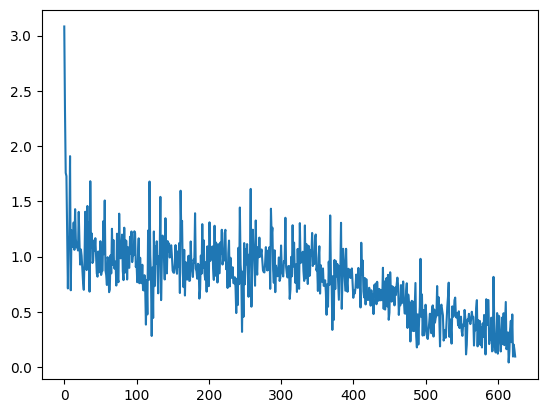

In [31]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

## Prediction 

In [32]:
question, text = 'What is south of the bedroom?','The hallway is south of the garden. The garden is south of the bedroom.'
input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]

print(type(outputs))

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
print(question, answer.capitalize())

<class 'tuple'>
What is south of the bedroom? Garden .
